## Modules

For this experiment, Python will be used with the following modules:
* Pandas
    + To tabulate results, and calculations in a csv format
* Matplotlib
	+ For visualization of the algorithm results performance
* Numpy & Random
    + For the generation of random values
* Os
    + To select the workspace path where the problem instance library is located

In [131]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy
import os

## Localizes the Knapsack Instances Library

In [132]:
os.chdir(r"C:\Users\xedua\OneDrive\Escritorio\MCC-I\Semester_2\Research\KP instances")

## Generator/Selector of PIs

Description of the **_«instances»_** function:

* The purpose of this function is to either return a tuple with problem instance objects (inside tuples) from the library with its knapsack limit, or to generate a random problem instance with objects of weight ∈ (1, 15) and value ∈ (1, 1/3 * knapsack limit)

* **_Parameters_**

    + number_objects: _Integer_
        - The amount of available objects that will contain the problem instance 
    + k_limit: Integer
        - The maximum units that a knapsack solution can contain
* **_Returns_**
    + PI: _List of tuples with integers_
        - Either the generated or the library selected problem instance, each object is a tuple of (profit, weight)
    + k_limit: _Integer_
        - Either the originally specified knapsack limit or the knapsack limit selected from the problem instance library

In [133]:
# Generator/Selector of PIs
def instances(number_objects, k_limit):
    if k_limit != 0: # When knapsack limit is defined, instances are generated
        PI = []
        for element in range(number_objects):
            PI.append((random.randint(1.0, 15.0), random.randint(1, k_limit//3))
            ) # Objects ∈ [value (1, 15), weight (1, 1/3kp)]
        return PI, k_limit
    else: # When knapsack limit undefined, an instance from the library is used
        fileName = "ks_" + str(number_objects) + "_0" # Introduces the number of
        # objects into the filename that will be requested from the library
        f = open(fileName, "r") # Opening, reading, and cleaning the instance
        lines = f.readlines()
        line = lines[0].split(",")
        nbItems = int(line[0].strip())
        k_limit = int(line[1].strip())
        PI = [None] * nbItems
        for i in range(0, nbItems):
            line = lines[i + 1].split(",")
            weight = int(line[0].strip())
            profit = float(line[1].strip())
            PI[i] = (profit, weight) # Saves objects as (profit, weight)
        return PI, k_limit # Returns the instance and the knapsack limit 

## Cellular Automata

Description of the **_«CA»_** function:

* The purpose of this function is to return one generation from the one dimensional Cellular Automata as a list of 0s and 1s, that represent the solution for the given problem instacne

* **_Parameters_**

    + rules: _List of lists_
        - The configuration of three neighborhood cells that will produce a cell from the **_rule_generator_** function
    + PI: _List of tuples with integers_
        - The either generated or selected problem instance from the **_«instances»_** function
* **_Returns_**
    + result: _List with integers_
        - A list of 0s and 1s that represent an actual solution for the knapsack problem instance

In [134]:
# Cellular Automata Solution Generator
def CA(rules, PI):
    initial_states = [] 
    rules_outcome = []
    number_rules = len(rules)
    neighborhood = len(rules[0])
    number_kp_items = len(PI)
    for element in range(number_kp_items): # Appends the PI len number of zeros
        if element == number_kp_items // 2 - 1:
            initial_states.append(1) # The initial state, middle active cell
        else: # For example in a PI of size 7, the initial is: [0 0 0 1 0 0 0]
            initial_states.append(0) 
    for element in range(number_rules): # Appends a 1s set for the rules outcome
        rules_outcome.append(1)
    generations = 1 # Defines the number of generations that will be produced, 
    rows = generations + 1 # The rows are the initial state and the result
    columns = len(initial_states) # The columns num are the kp availablr items
    canvas = numpy.zeros([rows, columns]) # Creates the array for the CA
    for i in range(len(initial_states)): 
        canvas[0, i] = initial_states[i] # Places the parent in the CA array
    for i in range(rows - 1): #  Iterates the whole canvas
        for j in range(columns):
            for k in range(number_rules):
                if numpy.array_equal(rules[k], canvas[i, j:(j + neighborhood)]): 
                    # Compares with the rules, when it matches...
                    canvas[i + 1, j + 1] = rules_outcome[k] # ...substitutes the
                    # canvas with the outcome
    # In case each CA solution needs to be visualize
    #plt.imshow(canvas[:, 0:columns], cmap='Greys', interpolation='nearest')
    result = []
    for element in canvas[1:].tolist()[0]: # The zero makes it return each 
        # element not the whole list
        result.append(element) # Appends the new generation, the solution
    return result # Returns the solution

## Evaluator of Solutions

Description of the **_«evaluator»_** function
* The purpose of this function is to evaluate the performance of the solution, it returns a tuple with the (total profit, total weight, state of the knapsack).

* **_Parameters_**
    + PI: _List of tuples with integers_
        - The either generated or selected problem instance from the **_«CA»_** function
    + Solution: _List of integers_
        - A random list with numbers ∈ (0, 1) ∨ (Outside Knapsack, Inside Knapsack) from the **_«solver»_** function
            - Each number makes reference to each object from the problem instance
    + k_limit: _Integer_
        - Either the originally specified knapsack limit or the knapsack limit selected from the problem instance library, from the **_«instances»_** function
* **_Returns_**
    + s1: _Tuple with integers_
        - A tuple with the total profit, total weight, and the state of the knapsack which may be 0 or 1
        

In [135]:
# Evaluator of Solutions
def evaluator(PI, solution, k_limit):
    s1 = (0, 0, 0)
    for i in range(len(PI)): # Iterates all the objects in the problem instance
        if solution[i] == 1: # When the object is in the knapsack considers the 
            # object in the evaluation
            s1 = (s1[0] + PI[i][0], s1[1] + PI[i][1]) # Sums up the profit and 
            # the weight of all the items
    if s1[1] <= k_limit: # When the knapsack is not broken saves a record of 0
        s1 = (s1[0], s1[1], 0)
    else:
        s1 = (s1[0], s1[1], 1) # When the knapsack is broken saves a record of 1
    return s1

## Rule generator

Description of the **_«rule_generator»_** function
* The purpose of this function is to create rules of a specified size, such rules will be splitted, and a list of lists contaning each rule will be returned.

* **_Parameters_**
    + number_rules: _Integer_
        - The amount of rules that are to be generated
    + size_rules: _Integers_
        - The size or length of each rule, it determines how many numbers each sublist or rule will contain 
* **_Returns_**
    + new_rules: _List of lists_
        - The specified number of generated rules with the already specified length.
        

In [136]:
# Generator of Random Rules
def rule_generator(number_rules, size_rules):
    rules = []
    number = number_rules * size_rules
    for element in range(number):
        rules.append(random.randint(0, 2)) # Appends 0s or 1s to complete rules
    start = 0
    end = len(rules)
    step = size_rules
    new_rules = []
    for i in range(start, end, step): # Breaks the 0s and 1s in sublists of 
        # 'size' length
        x = i
        new_rules.append(rules[x : x + step])
    return new_rules

## Analyzer of the Tests

Description of the **_«experiment_analyzer»_** function
* The purpose of this function is to average the performance in terms of profit, weight, and broken knapsacks of multiple experiments. Each experiment contains a sample of solutions, so for each experiment the sample size of solutions is always smaller by one than the previous, until reaching the base experiment which is of one.
* **_Parameters_**
    + PI: _List of tuples with integers_
        - The either generated or selected problem instance from the **_«instances»_** function
    + k_limit: _Integer_
        - Either the originally specified knapsack limit or the knapsack limit selected from the problem instance library, from the **_«instances»_** function
    + sample_size: _Integer_
        - The number of solutions that are to be generated and evaluated
    + number_rules: _Integer_
        - Amount of rules that will be generated
    + size_rules: _Integer_
        - The number of cells that determines the neighborhood or the size of the rule in terms of cells

* **_Returns_**
    + results: _Tuple with tuples with integers_
        - A tuple with tuples that contain the averaged profit, weight, with its deviations, and the probabiliy of having a broken a knapsack.
    + solutions: _Tuple with tuples with a tuple and a list_
        - A tuple that contains the evaluation and the corresponding solution (evaluation(tuple), solution(list)) from the **_«experiment»_** function

In [137]:
 # Analyzer of the Tests
 def experiment_analyzer(PI, k_limit, sample_size, number_rules, size_rules):
    results = []
    for i in range(1, sample_size + 1):
        # Executes experiments, for a sample size that is smaller by one than 
        # the previous experiment until reaching, the experiment with 1 solution
        solutions = experiment(PI,  k_limit, i, number_rules, size_rules)
        profits, weights, broken_ks = ([] for j in range(3))
        for solution in solutions:
            profits.append(solution[0][0]) # Average Profit of multiple solutions
            weights.append(solution[0][1]) # Counts Weight of multiple solutions
            broken_ks.append(solution[0][2]) # Counts Broken Knapsacks of multiple...
        results.append((numpy.average(profits), numpy.average(weights),
        numpy.average(broken_ks), numpy.std(profits), numpy.std(weights))) 
        # Appends the results from the analysis
    return results, solutions

## Experimenter of Solutions

Description of the **_«experiment»_** function
* The purpose of this function is to execute multiple solutions for a particular problem instance, and return a list of tuples with each tuple containing the (evaluation(tuple), solution(list)) for each solution/run
* **_Parameters_**
    + PI: _List of tuples with integers_
        - The either generated or selected problem instance from the **_«instances»_** function
    + k_limit: _Integer_
        - Either the originally specified knapsack limit or the knapsack limit selected from the problem instance library, from the **_«instances»_** function
    + sample_size: _Integer_
        - The number of solutions that are to be generated and evaluated, from the **_experiment_analyzer_** function
    + number_rules: _Integer_
        - Amount of rules that will be generated
    + size_rules: _Integer_
        - The number of cells that determines the neighborhood or the size of the rule in terms of cells
* **_Returns_**
    + solutions: List with tuples with a tuple and a list_
        - A list that contains the evaluation and the corresponding solution (evaluation(tuple), solution(list))

In [138]:
# Experimenter of Solutions
def experiment(PI, k_limit, sample_size, number_rules, size_rules):
    solutions = [] 
    for i in range(sample_size): # Produces sample_size number of solutions
        rules = rule_generator(number_rules, size_rules) # Creates random rules
        solution = CA(rules, PI) # Creates a solution for the random PI with the 
        # rules
        evaluation = evaluator(PI, solution, k_limit) # Evaluates the generated 
        # solutions
        solutions.append((evaluation, solution)) # Returns a list of tuples with 
        # the evaluation tuple and the solution list (((0, 0 , 1), [0, 1, 0, 0,
        # 1]),...) 
    return solutions

## Visualizer of Experiments Analysis

Description of the **_«visualizer»_** function
* The purpose of this function is to visualize the results from the other function **_experiment_analyzer_**
* **_Parameters_**
    + PI: _List of tuples with integers_
        - The either generated or selected problem instance from the **_«instances»_** function
    + k_limit: _Integer_
        - Either the originally specified knapsack limit or the knapsack limit selected from the problem instance library, from the **_«instances»_** function
    + sample_size: _Integer_
        - The number of solutions that are to be generated and evaluated, from the **_experiment_analyzer_** function
    + number_rules: _Integer_
        - Amount of rules that will be generated
    + size_rules: _Integer_
        - The number of cells that determines the neighborhood or the size of the rule in terms of cells
* **_Returns_**
    + solutions: _List with tuples with a tuple and a list_
        - A list that contains the evaluation and the corresponding solution (evaluation(tuple), solution(list))
    + results: _Tuple with tuples with integers_
        - A tuple with tuples that contain the averaged profit, weight, average number of broken knapsacks, and the probabiliy of having a broken a knapsack, from the **__«experimenter_analyzer»__** function
    + It display subplots of the averaged profit, weight and the probability of breaking a knapsack for each experiment of x runned solutions

In [139]:
# Visualizer of Experiments Analysis
def visualizer(PI_size, k_limit, sample_size, number_rules, size_rules):
    if k_limit == 0:
        type = 'Library'
    else:
        type = 'Random'
    PI, k_limit = instances(PI_size, k_limit) 
    results, solutions = experiment_analyzer(PI, k_limit, sample_size,
    number_rules, size_rules)
    print(f'The maximum knapsack size is: {k_limit}')
    print(f'Object set from {type} PI of {PI_size} items')
    print(f'The number of rules is of {number_rules}')
    # Folder for the results
    os.chdir(r"C:\Users\xedua\OneDrive\Escritorio\MCC-I\Semester_2\Research\Results")
    df = pd.DataFrame(results, columns = ['Profit_Avg', 'Weight_Avg',
    'BrokenKs_Prob', 'Profit_Std', 'Weight_Std'])
    df.index = range(1,len(df)+1)
    df.index.names = ['Executed_Solutions']
    df.to_csv(f'Results_RandCA_{type}_SelectedPI_{PI_size}_{k_limit}.csv',
    encoding='utf-8')

    y1, y2, y3 = ([] for i in range(3))
    for result in results:
        y1.append(result[0])
        y2.append(result[1])
        y3.append(result[2])
    y3 = [value * 100 for value in y3] # Passes the average to a probability
    fig = plt.figure()
    gs = fig.add_gridspec(3, hspace = 0.095) # 3 plots in vertical
    axs = gs.subplots(sharex = False, sharey = False) # Share x Axis
    fig.supxlabel('Number of Executed Knapsack Solutions')
    axs[0].plot(list(range(1, sample_size + 1)), y1)
    axs[1].plot(list(range(1, sample_size + 1)), y2)
    axs[2].plot(list(range(1, sample_size + 1)), y3)
    axs[0].set(ylabel = 'Average Profit')
    axs[1].set(ylabel = 'Average Weight');
    axs[2].set(ylabel = 'P(Broken K)');
    plt.savefig(f'Results_RandCA_{type}_KPI_{PI_size}_{k_limit}', transparent = False,
    dpi = 300)
    plt.show()
    plt.close(fig)

    profit = []
    weight = []
    broken_ks = 0
    for solution in solutions:
        profit.append(solution[0][0])
        weight.append(solution[0][1])
        broken_ks += solution[0][2]
    broken_ks_prob = broken_ks/sample_size*100
    
    fig = plt.figure(figsize =(5, 8))
    plt.boxplot(profit)
    plt.xlabel(f'Boxplot for profit of {sample_size} generated solutions')
    plt.ylabel('Profit Units')
    fig.savefig(f'Boxplot_Profit_RandCA_{type}_KPI_{PI_size}_{k_limit}',
    transparent = False, dpi = 300)
    plt.show()
    plt.close(fig)

    fig = plt.figure(figsize =(5, 8))
    plt.boxplot(weight)
    plt.xlabel(f'Boxplot for weight of {sample_size} generated solutions')
    plt.ylabel('Weight Units')
    fig.savefig(f'Boxplot_Weight_RandCA_{type}_KPI_{PI_size}_{k_limit}',
    transparent = False, dpi = 300)
    plt.show()
    plt.close(fig)

    print(f'''In {sample_size} executed solutions the amount of broken knapsacks 
    is {broken_ks}''')
    print(f'''In {sample_size} executed solutions the probability of having a 
    broken knapsack is of {broken_ks_prob}''')
    # Folder for the problem instances library
    os.chdir(r"C:\Users\xedua\OneDrive\Escritorio\MCC-I\Semester_2\Research\KP instances") 
    return results, solutions, PI, k_limit

## One Experiment Analyzer

Description of the **_«one_experiment_analyzer»_** function
* The purpose of this function is to average the performance in terms of profit, weight, and broken knapsacks of one experiment with a fixed sample size
* **_Parameters_**
    + PI: _List of tuples with integers_
        - The either generated or selected problem instance from the **_«instances»_** function
    + k_limit: _Integer_
        - Either the originally specified knapsack limit or the knapsack limit selected from the problem instance library, from the **_«instances»_** function
    + sample_size: _Integer_
        - The number of solutions that are to be generated and evaluated
    + number_rules: _Integer_
        - Amount of rules that will be generated
    + size_rules: _Integer_
        - The number of cells that determines the neighborhood or the size of the rule in terms of cells

* **_Returns_**
    + result: _Tuple_
        - A tuple with the averaged profit, weight, with its deviations, and the probabiliy of having a broken a knapsack.
    + solutions: _List with tuples with a tuple and a list_
        - A list that contains the evaluation and the corresponding solution (evaluation(tuple), solution(list)) from the **_«experiment»_** function

In [140]:
 # Analysis of one test
 def one_experiment_analyzer(PI, k_limit, sample_size, number_rules, size_rules):
    result = ()
    solutions = experiment(PI,  k_limit, sample_size, number_rules, size_rules)
    profits, weights, broken_ks = ([] for j in range(3))
    for solution in solutions:
        profits.append(solution[0][0]) # Average Profit of multiple solutions
        weights.append(solution[0][1]) # Counts Weight of multiple solutions
        broken_ks.append(solution[0][2]) # Counts Broken Knapsacks of multiple...
    result = (numpy.average(profits), numpy.average(weights),
    numpy.average(broken_ks), numpy.std(profits), numpy.std(weights))
    # Appends the result from the analysis
    return result, solutions

## Generator of solutions for multiple problem instances

Description of the **_«tabulator»_** function
* The purpose of this function is to obtain a sample size of solutions for multiple problem instance, only one run of multiple solutions is executed per problem instance, and returns a tabular with the performace in each problem instance
* **_Parameters_**
    + PI_sizes: _List of integers_
        - A set of sizes for the problem instance to be selected/generated
    + k_limits: _Integer_
        - Either a set of knapsack limits for the problem instances to be generated or a set of 0s indicating to the **_«instances»_** function that a problem instace needs to be extracted from the library
    + sample_size: _Integer_
        - The number of solutions that are to be generated and evaluated
    + number_rules: _Integer_
        - Amount of rules that will be generated
    + size_rules: _Integer_
        - The number of cells that determines the neighborhood or the size of the rule in terms of cells

* **_Returns_**
    + results: _List of tuples_
        - A list of tuple with the averaged profit, weight, with its deviations, and the probabiliy of having a broken a knapsack, for all the solved problem instances.
    + all_solutions: _List of sublists with tuples with a tuple that contain a tuple and a list_
        - A list that contains lists for all the solutions and evaluations performed for a problem instances [[(evaluation(tuple), solution(list))], PI2 sublist, PI3 sublist...]

In [141]:
# Generator of solutions for multiple problem instances
def tabulator(PI_sizes, k_limits, sample_size, number_rules, size_rules):
    results = []
    all_solutions = []

    for i in range(len(PI_sizes)):
        if k_limits[i] == 0:
            type = 'Library'
        else:
            type = 'Random'
        PI, k_limit = instances(PI_sizes[i], k_limits[i]) 
        result, solutions = one_experiment_analyzer(PI, k_limit, sample_size,
        number_rules, size_rules)
        results.append(result)
        all_solutions.append(solutions)
    # Folder to save results
    os.chdir(r"C:\Users\xedua\OneDrive\Escritorio\MCC-I\Semester_2\Research\Results")
    df = pd.DataFrame(results, columns = ['Profit_Avg', 'Weight_Avg',
    'BrokenKs_Prob', 'Profit_Std', 'Weight_Std'])
    df.index = PI_sizes
    df.index.names = ['Problem Instance']
    df.to_csv(f'Results_RandCA_{type}_Multi_SelectedPI.csv',
    encoding='utf-8')
    # Folder for the problem instances library
    os.chdir(r"C:\Users\xedua\OneDrive\Escritorio\MCC-I\Semester_2\Research\KP instances")
    return results, all_solutions    

## Execution of One Experiment

This executes 150 solutions **only once**  for all the instances from the problem instance library, except the ones with the subindex different from 0. Default File name of problem instances: ks_'PI-size'_'Subindex'

In [142]:
PI_sizes = [4, 19, 30, 40, 45, 50, 60, 82, 100, 106, 200, 300, 400, 500,
1000, 10000]
results, all_solutions = tabulator(PI_sizes, [0]*len(PI_sizes), 150, 8, 3)

## Execution of runs for multiple sample experiments

* Characteristics of the solution model:
    + Solutions are generated with the 1D Cellular Automata with the randomly generated rules
    + The neighborhood is of 3
    + One generation represents a asolution (row/vector)
    + The generated, not library selected objects weight from the problem instances do not exceed 1/3 the knapsack limit, and are not less than 1
    + The generated, not library selected objects profit from the problem instances does not exceed 15 units or are less than 1

### Run #1

The maximum knapsack size is: 30
Object set from Random PI of 15 items
The number of rules is of 8


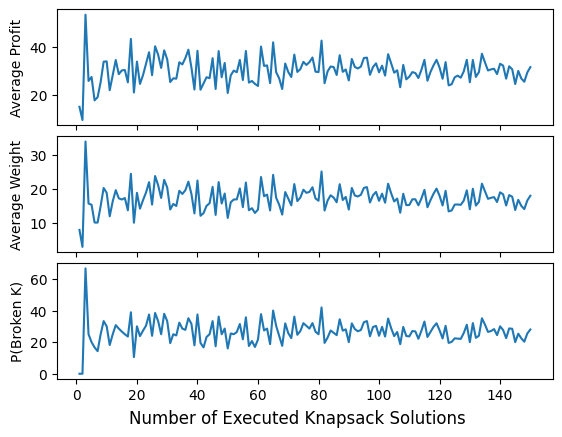

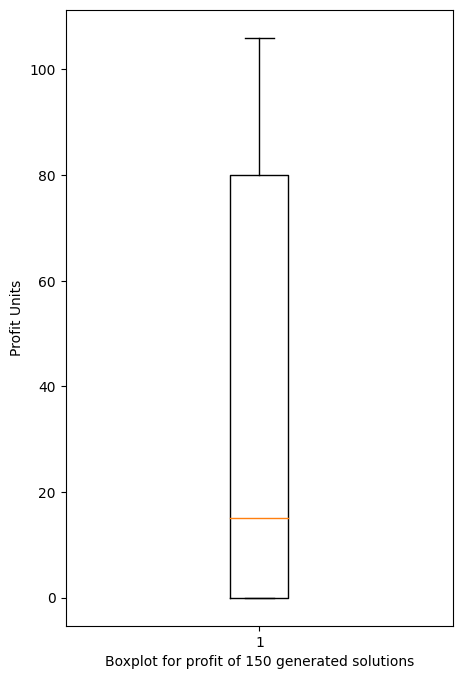

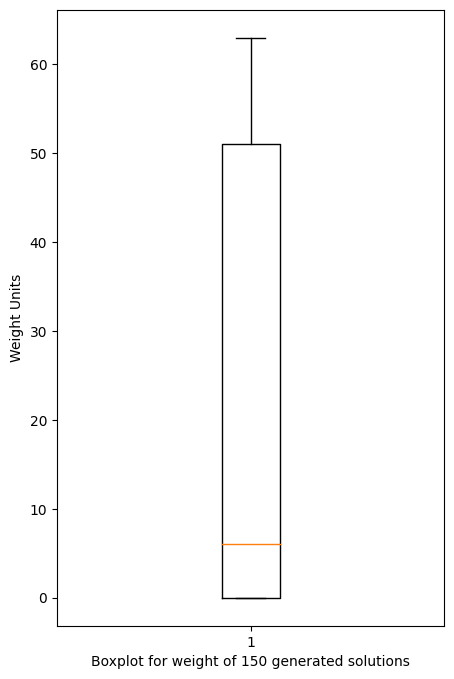

In 150 executed solutions the amount of broken knapsacks 
    is 42
In 150 executed solutions the probability of having a 
    broken knapsack is of 28.000000000000004


In [143]:
results_1, solutions_1, PI_1, k_limit_1 = visualizer(15, 30, 150, 8, 3) 
# (Number_PI, k_limit), when the knapsack limit is 0, a PI from the library will
# be selected

### Run #2

The maximum knapsack size is: 30
Object set from Random PI of 15 items
The number of rules is of 4


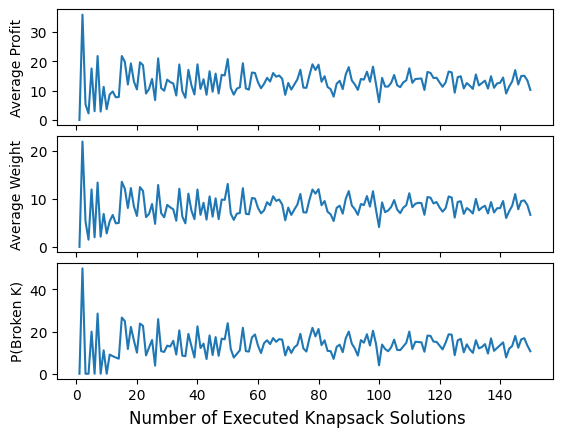

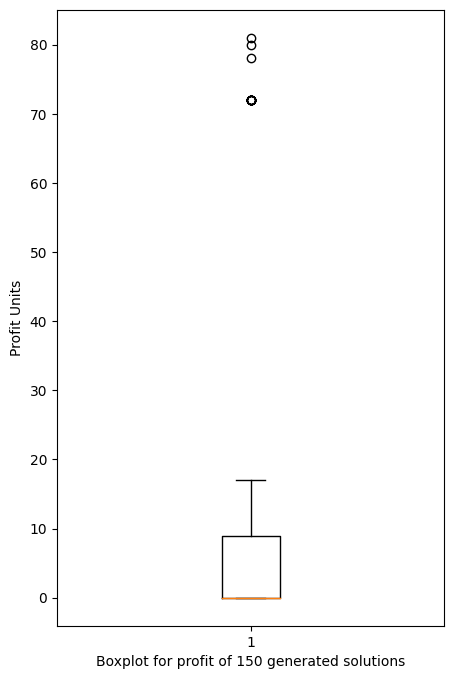

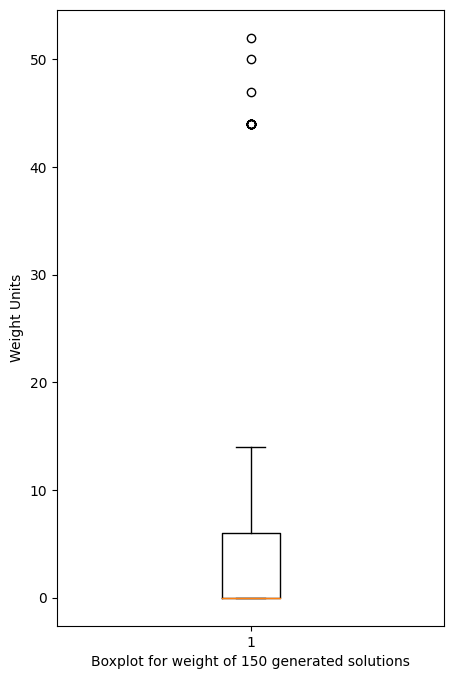

In 150 executed solutions the amount of broken knapsacks 
    is 16
In 150 executed solutions the probability of having a 
    broken knapsack is of 10.666666666666668


In [144]:
results_2, solutions_2, PI_2, k_limit_2 = visualizer(15, 30, 150, 4, 3)
# (Number_PI, k_limit), when the knapsack limit is 0, a PI from the library will 
# be selected

### Run #3

The maximum knapsack size is: 30
Object set from Random PI of 15 items
The number of rules is of 3


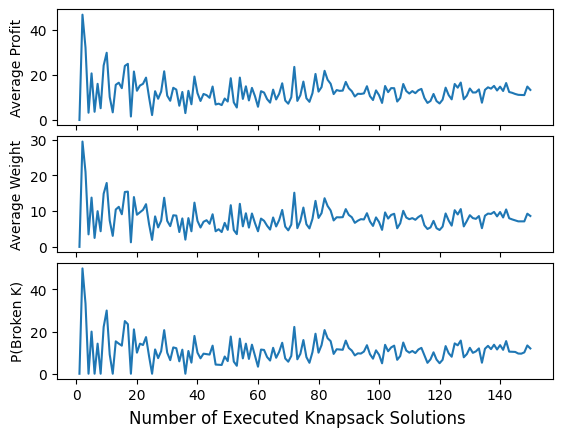

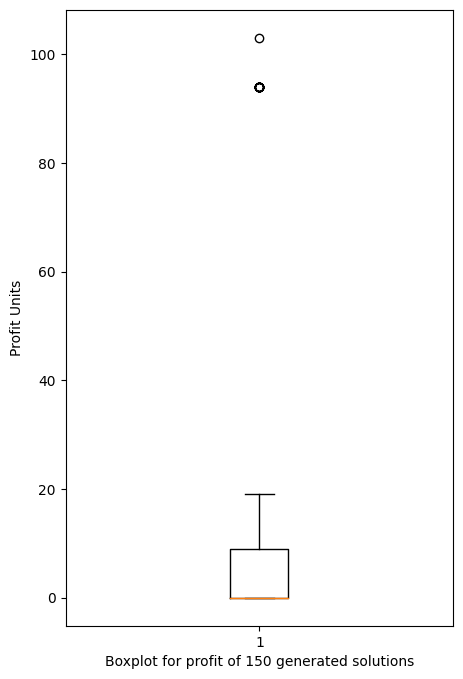

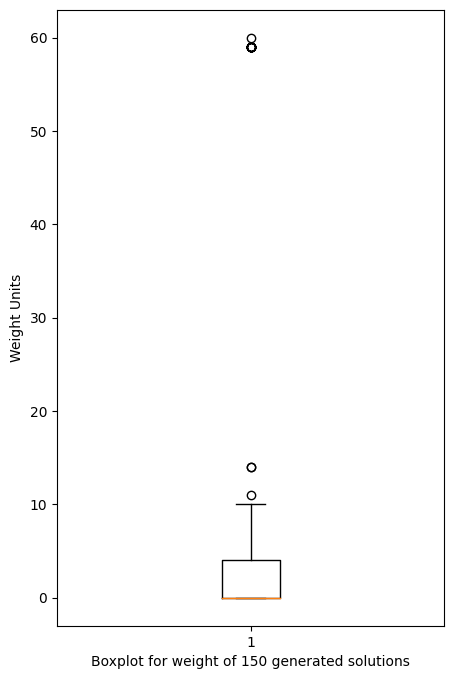

In 150 executed solutions the amount of broken knapsacks 
    is 18
In 150 executed solutions the probability of having a 
    broken knapsack is of 12.0


In [145]:
# Test #3
results_3, solutions_3, PI_3, k_limit_3 = visualizer(15, 30, 150, 3, 3)
# (Number_PI, k_limit), when the knapsack limit is 0, a PI from the library will 
# be selected

### Run #4

The maximum knapsack size is: 30
Object set from Random PI of 30 items
The number of rules is of 8


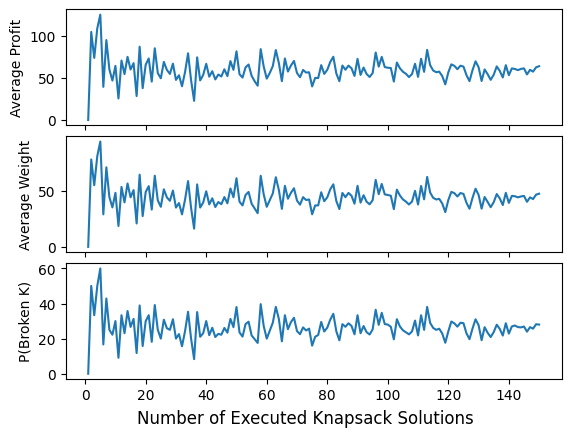

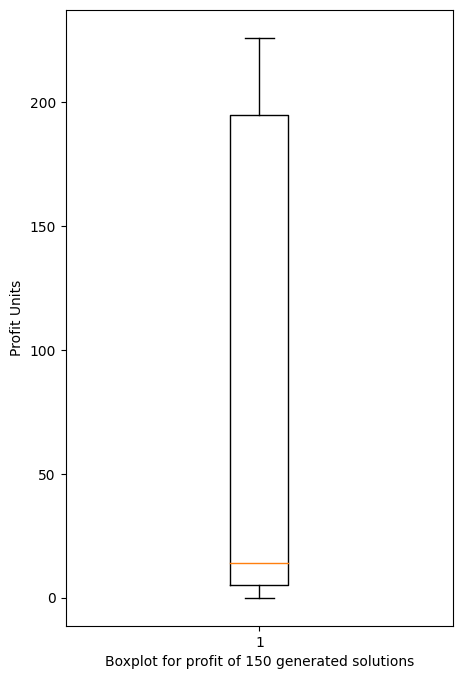

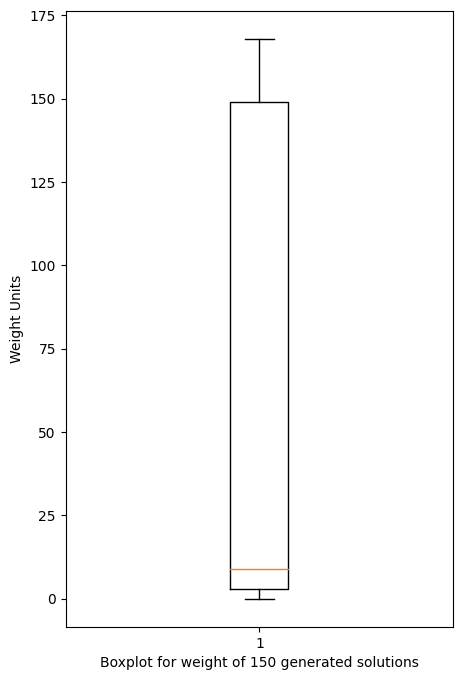

In 150 executed solutions the amount of broken knapsacks 
    is 42
In 150 executed solutions the probability of having a 
    broken knapsack is of 28.000000000000004


In [146]:
results_4, solutions_4, PI_4, k_limit_4 = visualizer(30, 30, 150, 8, 3)
# (Number_PI, k_limit), when the knapsack limit is 0, a PI from the library will 
# be selected

### Run #5

The maximum knapsack size is: 30
Object set from Random PI of 60 items
The number of rules is of 8


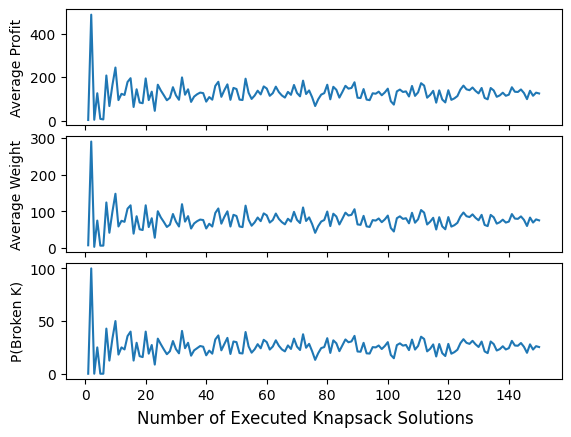

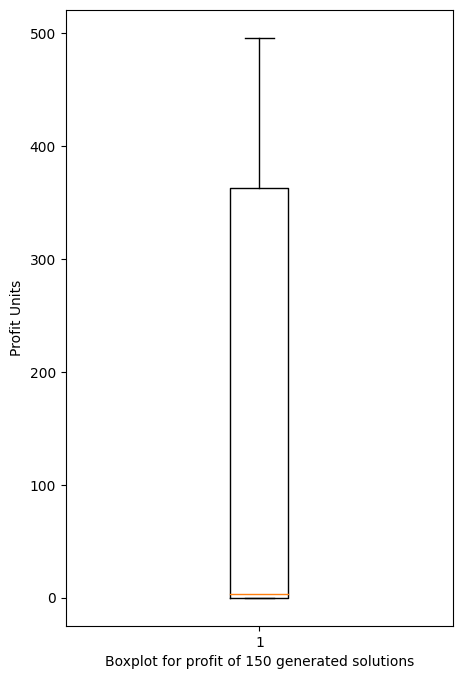

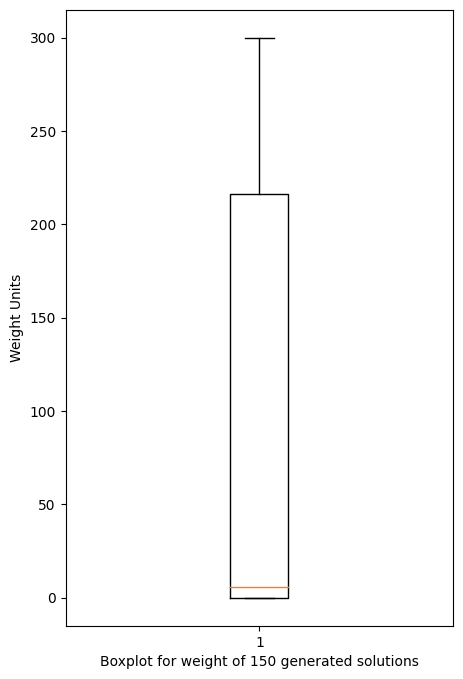

In 150 executed solutions the amount of broken knapsacks 
    is 38
In 150 executed solutions the probability of having a 
    broken knapsack is of 25.333333333333336


In [147]:
results_5, solutions_5, PI_5, k_limit_5 = visualizer(60, 30, 150, 8, 3)
# (Number_PI, k_limit), when the knapsack limit is 0, a PI from the library will 
# be selected

### Run #6

The maximum knapsack size is: 30
Object set from Random PI of 90 items
The number of rules is of 8


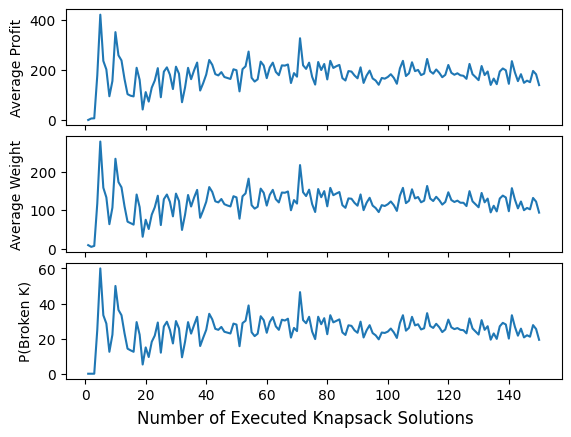

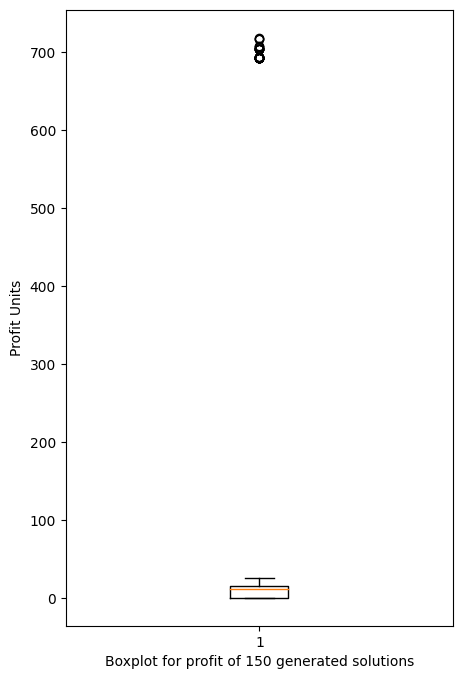

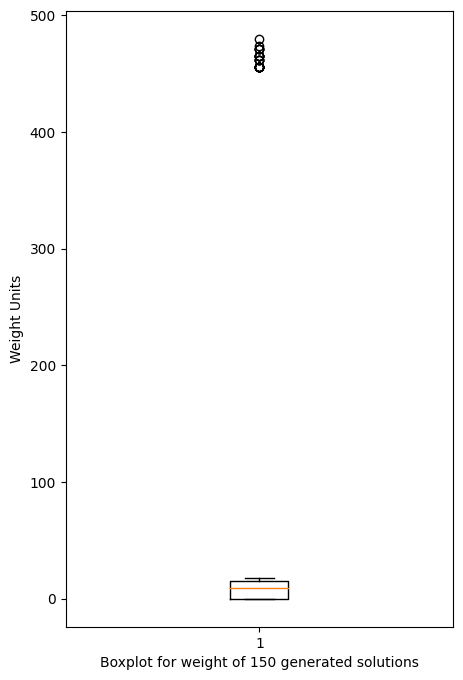

In 150 executed solutions the amount of broken knapsacks 
    is 29
In 150 executed solutions the probability of having a 
    broken knapsack is of 19.333333333333332


In [148]:
results_6, solutions_6, PI_6, k_limit_6 = visualizer(90, 30, 150, 8, 3)
# (Number_PI, k_limit), when the knapsack limit is 0, a PI from the library will 
# be selected

### Run #7

The maximum knapsack size is: 31181
Object set from Library PI of 19 items
The number of rules is of 8


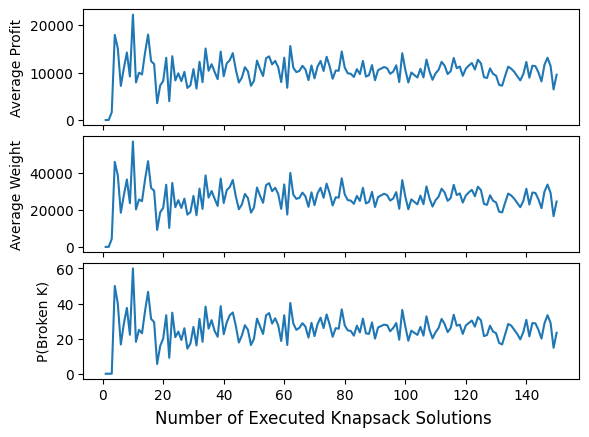

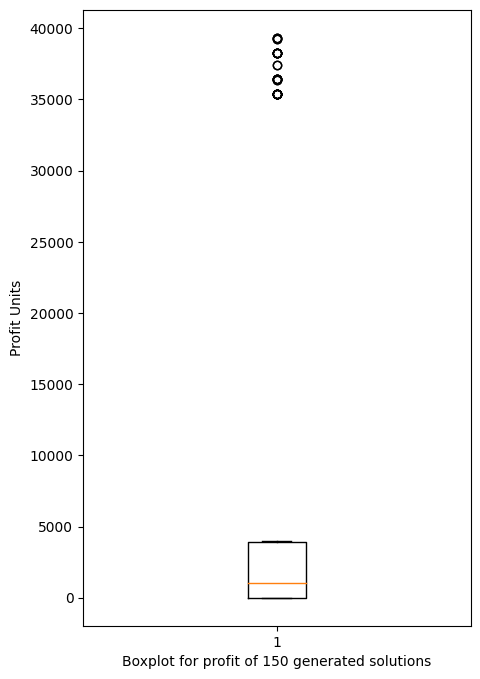

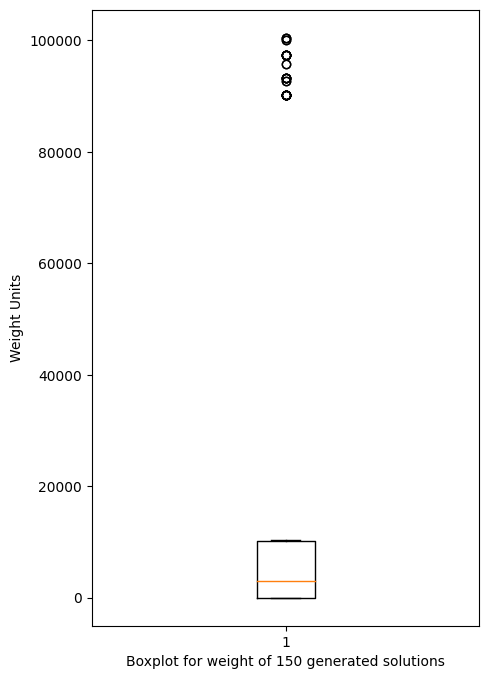

In 150 executed solutions the amount of broken knapsacks 
    is 35
In 150 executed solutions the probability of having a 
    broken knapsack is of 23.333333333333332


In [149]:
results_7, solutions_7, PI_7, k_limit_7 = visualizer(19, 0, 150, 8, 3)
# (Number_PI, k_limit), when the knapsack limit is 0, a PI from the library will 
# be selected

### Run #8

The maximum knapsack size is: 100000
Object set from Library PI of 40 items
The number of rules is of 8


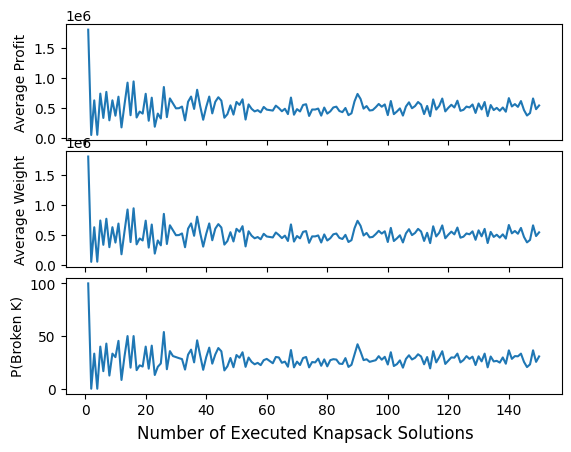

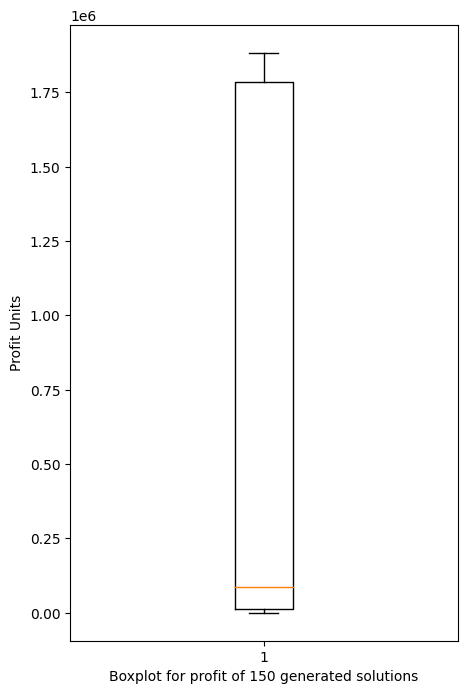

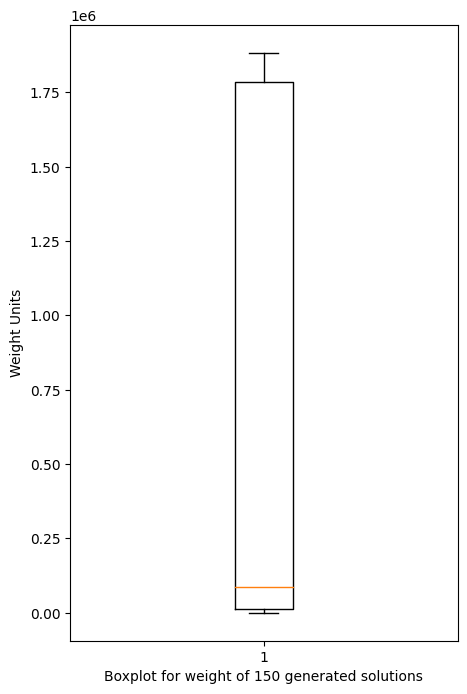

In 150 executed solutions the amount of broken knapsacks 
    is 46
In 150 executed solutions the probability of having a 
    broken knapsack is of 30.666666666666664


In [150]:
results_8, solutions_8, PI_8, k_limit_8 = visualizer(40, 0, 150, 8, 3)
# (Number_PI, k_limit), when the knapsack limit is 0, a PI from the library will 
# be selected

### Run #9

The maximum knapsack size is: 100000
Object set from Library PI of 60 items
The number of rules is of 8


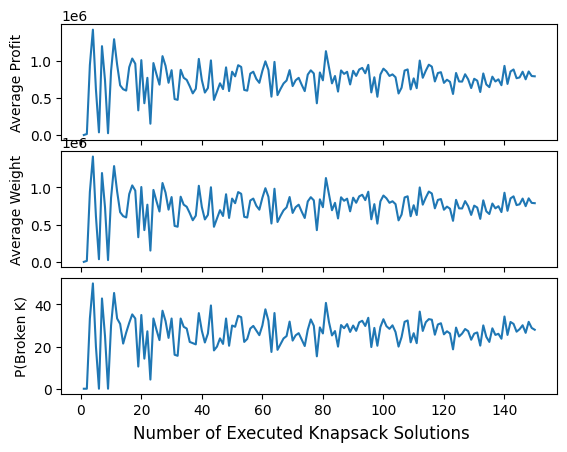

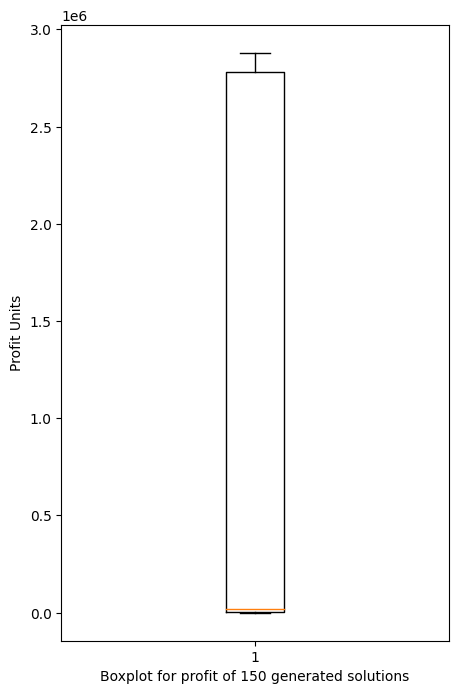

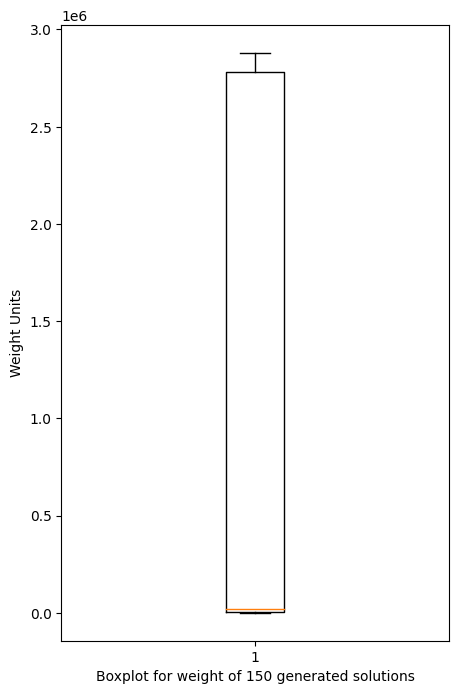

In 150 executed solutions the amount of broken knapsacks 
    is 42
In 150 executed solutions the probability of having a 
    broken knapsack is of 28.000000000000004


In [151]:
results_9, solutions_9, PI_9, k_limit_9 = visualizer(60, 0, 150, 8, 3)
# (Number_PI, k_limit), when the knapsack limit is 0, a PI from the library will 
# be selected